在minist手写数字上训练vae图像生成模型

In [8]:
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
# 超参数定义
from dataclasses import dataclass


@dataclass
class Config:
    # 文件&数据
    data_path: str = "./dataset/mnist"
    save_dir: str = "./checkpoints"
    save_every: int = 10
    transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        # tv.transforms.Normalize((0.5,), (0.5,))
    ])
    # 训练参数
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size: int = 256
    num_workers: int = 4
    lr: float = 1e-4
    num_epochs: int = 300
    # 模型参数
    img_size = 28
    latent_dim = 16

g_opt = Config()

In [10]:
# 数据集
from torch.utils.data import DataLoader


train_dataset = tv.datasets.MNIST(
    root=g_opt.data_path,
    train=True,
    transform=g_opt.transform,
    download=True
)
test_dataset = tv.datasets.MNIST(
    root=g_opt.data_path,
    train=False,
    transform=g_opt.transform,
    download=True
)
print(f"共有{len(train_dataset)}张训练图片，{len(test_dataset)}张测试图片")
# 数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=g_opt.batch_size,
    shuffle=True,
    num_workers=g_opt.num_workers
)
val_loader = DataLoader(
    test_dataset,
    batch_size=g_opt.batch_size,
    shuffle=False,
    num_workers=g_opt.num_workers
)


共有60000张训练图片，10000张测试图片


In [ ]:
# Utility

def save_images(tensor, fn, nrow=8, padding=2):
    """
    保存图像
    """
    grid = tv.utils.make_grid(tensor, nrow=nrow, padding=padding)
    tv.utils.save_image(grid, fn)

# Loss
def vae_loss(recon_x, x, mu, logvar):
    # x: (batch_size, 1, 28, 28)
    # mu: (batch_size, latent_dim)
    # logvar: (batch_size, latent_dim)
    batch_size = x.size(0)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / batch_size
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size

    return recon_loss + kld, recon_loss, kld

In [12]:
# VAE Model
from typing import Tuple


class VAE(nn.Module):
    def __init__(self, img_size, latent_dim):
        super(VAE, self).__init__()
        self.img_size = img_size # 28
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1), # (B, 1, 28, 28) -> (B, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1), # (B, 16, 14, 14) -> (B, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (B, 32, 7, 7) -> (B, 64, 4, 4)
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(64 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(64 * 4 * 4, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 64 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 4, 4)), # h: (batch_size, 64, 4, 4)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1), # (B, 64, 4, 4) -> (B, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # (B, 32, 7, 7) -> (B, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1), # (B, 16, 14, 14) -> (B, 1, 28, 28)
            nn.Sigmoid(),
        )
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode(self, x) -> Tuple[torch.Tensor, torch.Tensor]:
        # x: (batch_size, 1, 28, 28)
        h = self.encoder(x) # h: (batch_size, 64, 3, 3)
        h = h.view(h.size(0), -1) # h: (batch_size, 64 * 3 * 3)
        return self.fc_mu(h), self.fc_logvar(h) # (batch_size, latent_dim)
    
    def decode(self, z):
        # z: (batch_size, latent_dim)
        h = self.decoder_input(z) # h: (batch_size, 64 * 3 * 3)
        return self.decoder(h) # (batch_size, 1, 28, 28)
    
    def reparameterize(self, mu, logvar):
        # mu: (batch_size, latent_dim)
        # logvar: (batch_size, latent_dim)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std



In [ ]:
from tqdm import tqdm

def train_epoch(model, train_loader, optimizer, device):
    model.train()
    train_loss, recon_loss, kld_loss = 0, 0, 0
    for x, y in train_loader:
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        loss, recon_loss, kld_loss = vae_loss(recon_x, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        recon_loss += recon_loss.item()
        kld_loss += kld_loss.item()
        
    return train_loss/len(train_loader), recon_loss/len(train_loader), kld_loss/len(train_loader)

def val_epoch(model, val_loader, device):
    model.eval()
    with torch.no_grad():
        val_loss, recon_loss, kld_loss = 0, 0, 0
        for x, y in val_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss, recon_loss, kld_loss = vae_loss(recon_x, x, mu, logvar)
            val_loss += loss.item()
            recon_loss += recon_loss.item()
            kld_loss += kld_loss.item()
            
    return val_loss/len(val_loader), recon_loss/len(val_loader), kld_loss/len(val_loader)

def save_epoch(model, test_loader, epoch, device, times=1):
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            save_images(recon_x.cpu(), f"{g_opt.save_dir}/recon_epoch_{epoch}_{times}.png")
            if times == 0:
                break
            times -= 1


def train(model, train_loader, val_loader, optimizer, device, num_epochs):
    model.to(device)
    best_loss = float('inf')

    epoch_pbar = tqdm(range(num_epochs), desc="Epochs", position=0)

    for epoch in epoch_pbar:
        train_loss, _, _ = train_epoch(model, train_loader, optimizer, device)
        val_loss, recon_loss, kld_loss = val_epoch(model, val_loader, device)
        epoch_pbar.set_postfix(
            Train=f"{train_loss:.4f}",
            Test=f"{val_loss:.4f}",
            Recon=f"{recon_loss:.3f}",
            KLD=f"{kld_loss:.3f}"
        )
        # print(f"Epoch {epoch+1}/{num_epochs} TrainLoss: {train_loss:.4f} TestLoss: {val_loss:.4f} ReconLoss: {recon_loss:.3f} KLD: {kld_loss:.3f}")        
        cur_val_loss = val_loss
        # 保存最佳模型
        if cur_val_loss < best_loss:
            best_loss = cur_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss
            }, f"{g_opt.save_dir}/best.pth")
            
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': cur_val_loss
        }, f"{g_opt.save_dir}/last.pth")

        # if epoch % g_opt.save_every == 0 or epoch == num_epochs - 1 or epoch == 0:
        #     save_epoch(model, val_loader, epoch, device, times=1)



In [14]:
model = VAE(img_size=g_opt.img_size, latent_dim=g_opt.latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=g_opt.lr)
train(model, train_loader, val_loader, optimizer, g_opt.device, g_opt.num_epochs)

Epochs: 100%|██████████| 300/300 [04:15<00:00,  1.18it/s, KLD=0.651, Recon=0.585, Test=27.6391, Train=27.8458]


测试集图像重建效果：


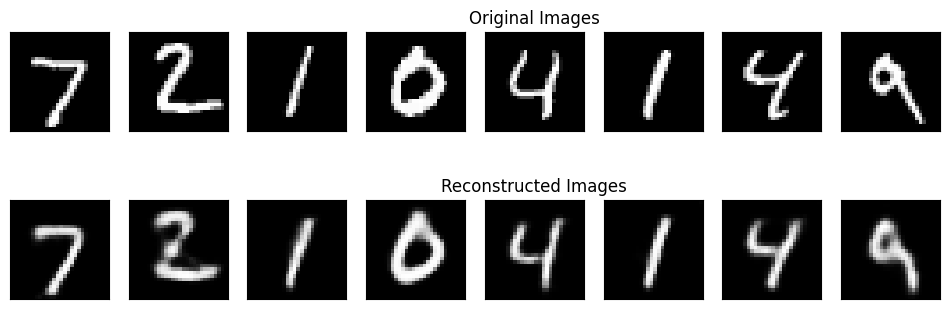

In [15]:
import matplotlib.pyplot as plt
best_model = VAE(img_size=g_opt.img_size, latent_dim=g_opt.latent_dim)
best_model.load_state_dict(torch.load(f"{g_opt.save_dir}/best.pth")['model_state_dict'])
best_model.to(g_opt.device)

# 展示VAE的生成效果
best_model.eval()


dataiter = iter(val_loader)
images, labels = next(dataiter)
images = images.to(g_opt.device)

# 使用模型进行重建（不计算梯度）
with torch.no_grad():
    reconstructed_images, mu, logvar = model(images)

# 将张量移动回CPU以便用matplotlib可视化
images_cpu = images.cpu()
reconstructed_images_cpu = reconstructed_images.cpu()

# 定义一个函数来可视化原始图片和重建图片
def show_reconstructions(original, reconstructed, n=8):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # 显示原始图片
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original Images')
        
        # 显示重建图片
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed Images')
    plt.show()

# 展示前8张图片的重建效果
print("测试集图像重建效果：")
show_reconstructions(images_cpu, reconstructed_images_cpu, n=8)
